# Task 2 — Sentiment and Thematic Analysis (Fintech App Reviews)

This notebook satisfies the Task‑2 requirements:

## Sentiment
- Model: `distilbert-base-uncased-finetuned-sst-2-english`
- Output: `p_pos`, `p_neg`, signed `sentiment_score = p_pos - p_neg`
- Labeling with **neutral margin**: if `|p_pos - p_neg| < margin` → `NEUTRAL`
- Aggregations: by **bank**, and by **bank × rating**

## Themes
- Keyword extraction with **TF‑IDF** (1–2 grams)
- Manual/rule‑based clustering into **3–5 themes per bank**
- Example reviews per theme

## Outputs
Written to `data/processed/task2/`:
- `reviews_task2_scored.csv`
- `task2_sentiment_by_bank.csv`
- `task2_sentiment_by_bank_rating.csv`
- `task2_keywords_tfidf_by_bank.csv`
- `task2_theme_examples.csv`

## Visualizations (added)
This version includes Task‑2 stakeholder visualizations using:
- `src/bank_reviews/viz/plots.py`
- `src/bank_reviews/viz/wordclouds.py` (optional dependency)


In [1]:
from __future__ import annotations

import re
import hashlib
from pathlib import Path

import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)

# Heavy deps used only for sentiment
HAS_TRANSFORMERS = True
try:
    from transformers import pipeline
except Exception as e:
    HAS_TRANSFORMERS = False
    print('Transformers not importable. Install torch + transformers for distilBERT sentiment.')
    print('Error:', e)

from sklearn.feature_extraction.text import TfidfVectorizer


d:\Python\Week 12\Customer-Experience-Analytics-for-Fintech-Apps-Updated\MMenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0) Prefer project modules (`bank_reviews.*`) when available

Because you run with `PYTHONPATH=src`, these imports should work.
If they don’t, the notebook uses fallbacks.


In [2]:
import sys
from pathlib import Path
USE_PROJECT_MODULES = True

PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

SRC = PROJECT_ROOT / "src"
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

try:
    from bank_reviews.utils.text import make_review_id as make_review_id_project
    from bank_reviews.utils.text import normalize_text as normalize_text_project

    from bank_reviews.nlp.sentiment import SentimentConfig as SentimentConfigProject
    from bank_reviews.nlp.sentiment import add_sentiment_columns as add_sentiment_columns_project
    from bank_reviews.nlp.sentiment import label_from_probs as label_from_probs_project

    from bank_reviews.nlp.themes import ThemeConfig as ThemeConfigProject
    from bank_reviews.nlp.themes import add_theme_columns as add_theme_columns_project

    from bank_reviews.nlp.keywords import top_keywords_by_bank as top_keywords_by_bank_project

    from bank_reviews.analysis.metrics import sentiment_aggregates_by_bank as sent_agg_by_bank_project
    from bank_reviews.analysis.metrics import sentiment_aggregates_by_bank_rating as sent_agg_by_bank_rating_project

    from bank_reviews.analysis.scenarios import sample_theme_examples as sample_theme_examples_project

    print('Using project modules: bank_reviews.*')
except Exception as e:
    USE_PROJECT_MODULES = False
    print('Could not import project modules; using fallback implementations.')
    print('Error:', e)

Using project modules: bank_reviews.*


## 1) Paths & load Task‑1 cleaned data

Expected input: `data/processed/reviews_task1_clean.csv`

Columns: `review, rating, date, bank, source`


In [3]:
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

IN_CSV = PROJECT_ROOT / "data" / "processed" / "reviews_task1_clean.csv"
OUT_DIR = PROJECT_ROOT / "data" / "processed" / "task2"
OUT_DIR.mkdir(parents=True, exist_ok=True)

print('Project root:', PROJECT_ROOT)
print('Input CSV:', IN_CSV, 'exists=', IN_CSV.exists())
print('Output dir:', OUT_DIR)

df = pd.read_csv(IN_CSV)
df.head()

Project root: d:\Python\Week 12\Customer-Experience-Analytics-for-Fintech-Apps-Updated
Input CSV: d:\Python\Week 12\Customer-Experience-Analytics-for-Fintech-Apps-Updated\data\processed\reviews_task1_clean.csv exists= True
Output dir: d:\Python\Week 12\Customer-Experience-Analytics-for-Fintech-Apps-Updated\data\processed\task2


,review,rating,date,bank,source
0,"Great App!!! Some times it may become busy,but...",5,2026-02-17,CBE,Google Play
1,it's nice app for me,5,2026-02-17,CBE,Google Play
2,I like it very much.Thank you,5,2026-02-17,CBE,Google Play
3,good👍,5,2026-02-17,CBE,Google Play
4,good,5,2026-02-16,CBE,Google Play


In [4]:
required_cols = {'review','rating','date','bank','source'}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f'Missing required columns: {missing}. Found: {list(df.columns)}')

df = df.copy()
df['review'] = df['review'].astype(str)
df['bank'] = df['bank'].astype(str)
df['source'] = df['source'].astype(str)
df['date'] = df['date'].astype(str)
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

print('Rows:', len(df))
df[['bank','source','rating']].value_counts().head(10)

Rows: 1800


bank    source       rating
DASHEN  Google Play  5         407
CBE     Google Play  5         400
BOA     Google Play  5         290
                     1         223
DASHEN  Google Play  1         100
CBE     Google Play  1          87
                     4          44
DASHEN  Google Play  4          39
BOA     Google Play  3          37
CBE     Google Play  3          36
Name: count, dtype: int64

## 2) Create deterministic `review_id`

Uses your project’s `make_review_id()` if available; otherwise fallback SHA‑1 over:
`bank||source||date||rating||review`


In [5]:
def make_review_id_fallback(*, review: str, bank: str, source: str, date: str, rating: float | int | str) -> str:
    raw = f"{bank}||{source}||{date}||{rating}||{review}"
    return hashlib.sha1(raw.encode('utf-8')).hexdigest()

def normalize_text_fallback(s: str) -> str:
    s = str(s).strip()
    s = re.sub(r"\s+", " ", s)
    return s

make_review_id = make_review_id_project if USE_PROJECT_MODULES else make_review_id_fallback
normalize_text = normalize_text_project if USE_PROJECT_MODULES else normalize_text_fallback

df['review_id'] = [
    make_review_id(review=r, bank=b, source=s, date=d, rating=rt)
    for r,b,s,d,rt in zip(df['review'], df['bank'], df['source'], df['date'], df['rating'])
]

df[['review_id','bank','rating','review']].head()

,review_id,bank,rating,review
0,12ba466236b469a3779f998af2726e1df0d2a3d7,CBE,5,"Great App!!! Some times it may become busy,but..."
1,d3428e5bbfcc391a4c2bb902380eabd63e3ff29a,CBE,5,it's nice app for me
2,7e27caeaa81813b83feebccb2f2ba81f29726939,CBE,5,I like it very much.Thank you
3,5f3f5ca8f6bebfc7c71a1ecf9d94368cf508e183,CBE,5,good👍
4,0e1866ef5ea6a7e5d9ba1ad6cfdc0b6372ed2a91,CBE,5,good


## 3) Sentiment analysis (distilBERT)


In [6]:
NEUTRAL_MARGIN = 0.15
BATCH_SIZE = 32
MODEL_NAME = 'distilbert-base-uncased-finetuned-sst-2-english'

def label_from_probs_fallback(p_pos: float, p_neg: float, neutral_margin: float = NEUTRAL_MARGIN) -> str:
    if abs(p_pos - p_neg) < neutral_margin:
        return 'NEUTRAL'
    return 'POSITIVE' if p_pos > p_neg else 'NEGATIVE'

def add_sentiment_columns_fallback(df_in: pd.DataFrame) -> pd.DataFrame:
    if not HAS_TRANSFORMERS:
        raise RuntimeError('Transformers not available. Install torch + transformers.')

    clf = pipeline(
        'sentiment-analysis',
        model=MODEL_NAME,
        device=-1,
        top_k=None,
    )

    texts = df_in['review'].astype(str).map(normalize_text).tolist()
    p_pos_list, p_neg_list, score_list, label_list = [], [], [], []

    for i in range(0, len(texts), BATCH_SIZE):
        batch = texts[i:i+BATCH_SIZE]
        results = clf(batch)
        for r in results:
            score_map = {d['label'].upper(): float(d['score']) for d in r}
            p_pos = score_map.get('POSITIVE', 0.0)
            p_neg = score_map.get('NEGATIVE', 0.0)
            s = p_pos - p_neg
            lab = label_from_probs_fallback(p_pos, p_neg, NEUTRAL_MARGIN)
            p_pos_list.append(p_pos)
            p_neg_list.append(p_neg)
            score_list.append(s)
            label_list.append(lab)

    out = df_in.copy()
    out['p_pos'] = p_pos_list
    out['p_neg'] = p_neg_list
    out['sentiment_score'] = score_list
    out['sentiment_label'] = label_list
    return out

if USE_PROJECT_MODULES:
    df = add_sentiment_columns_project(df, SentimentConfigProject())
    label_from_probs = label_from_probs_project
else:
    df = add_sentiment_columns_fallback(df)
    label_from_probs = label_from_probs_fallback

df[['sentiment_label','sentiment_score','p_pos','p_neg']].head()

Device set to use cpu


,sentiment_label,sentiment_score,p_pos,p_neg
0,POSITIVE,0.986176,0.993088,0.006912
1,POSITIVE,0.999668,0.999834,0.000166
2,POSITIVE,0.999746,0.999873,0.000127
3,NEGATIVE,-0.394113,0.302944,0.697056
4,POSITIVE,0.999632,0.999816,0.000184


In [7]:
coverage = df['sentiment_label'].notna().mean()
print('Sentiment coverage:', round(coverage * 100, 2), '%')
df['sentiment_label'].value_counts(dropna=False)

Sentiment coverage: 100.0 %


sentiment_label
POSITIVE    1055
NEGATIVE     737
NEUTRAL        8
Name: count, dtype: int64

## 4) Aggregate sentiment by bank and rating


In [8]:
def sent_agg_by_bank_fallback(df_in: pd.DataFrame) -> pd.DataFrame:
    return (
        df_in.groupby('bank', as_index=False)
            .agg(
                n_reviews=('review_id','count'),
                mean_sentiment=('sentiment_score','mean'),
                share_pos=('sentiment_label', lambda s: (s=='POSITIVE').mean()),
                share_neg=('sentiment_label', lambda s: (s=='NEGATIVE').mean()),
                share_neu=('sentiment_label', lambda s: (s=='NEUTRAL').mean()),
            )
    )

def sent_agg_by_bank_rating_fallback(df_in: pd.DataFrame) -> pd.DataFrame:
    return (
        df_in.groupby(['bank','rating'], as_index=False)
            .agg(
                n_reviews=('review_id','count'),
                mean_sentiment=('sentiment_score','mean'),
                share_pos=('sentiment_label', lambda s: (s=='POSITIVE').mean()),
                share_neg=('sentiment_label', lambda s: (s=='NEGATIVE').mean()),
                share_neu=('sentiment_label', lambda s: (s=='NEUTRAL').mean()),
            )
    )

if USE_PROJECT_MODULES:
    sent_by_bank = sent_agg_by_bank_project(df)
    sent_by_bank_rating = sent_agg_by_bank_rating_project(df)
else:
    sent_by_bank = sent_agg_by_bank_fallback(df)
    sent_by_bank_rating = sent_agg_by_bank_rating_fallback(df)


display(sent_by_bank.sort_values('mean_sentiment_score', ascending=False))
display(sent_by_bank_rating.sort_values(['bank', 'rating']))

,bank,n_reviews,mean_sentiment_score,pos_rate,neg_rate,neutral_rate
2,DASHEN,600,0.372003,0.675000,0.323333,0.001667
1,CBE,600,0.332677,0.648333,0.343333,0.008333
0,BOA,600,-0.087054,0.435000,0.561667,0.003333


,bank,rating,n_reviews,mean_sentiment_score,pos_rate,neg_rate,neutral_rate
0,BOA,1,223,-0.839111,0.067265,0.928251,0.004484
1,BOA,2,19,-0.683263,0.105263,0.894737,0.000000
2,BOA,3,37,-0.192988,0.405405,0.594595,0.000000
3,BOA,4,31,-0.004820,0.483871,0.516129,0.000000
4,BOA,5,290,0.535039,0.737931,0.258621,0.003448
5,CBE,1,87,-0.775796,0.103448,0.896552,0.000000
6,CBE,2,33,-0.426705,0.272727,0.696970,0.030303
7,CBE,3,36,-0.182460,0.388889,0.611111,0.000000
8,CBE,4,44,0.377535,0.659091,0.340909,0.000000
9,CBE,5,400,0.677846,0.820000,0.170000,0.010000


## 5) Keyword extraction (TF‑IDF 1–2 grams)


In [9]:
def top_keywords_by_bank_fallback(
    df_in: pd.DataFrame,
    top_k: int = 30,
    ngram_range=(1,2),
    min_df: int = 2,
    max_df: float = 0.95,
) -> pd.DataFrame:
    rows = []
    for bank, dfg in df_in.groupby('bank'):
        texts = dfg['review'].astype(str).map(normalize_text).tolist()
        if len(texts) < 3:
            continue
        vec = TfidfVectorizer(
            stop_words='english',
            ngram_range=ngram_range,
            min_df=min_df,
            max_df=max_df,
        )
        X = vec.fit_transform(texts)
        terms = np.array(vec.get_feature_names_out())
        scores = np.asarray(X.mean(axis=0)).ravel()
        idx = np.argsort(scores)[::-1][:top_k]
        for rank, j in enumerate(idx, start=1):
            rows.append({
                'bank': bank,
                'rank': rank,
                'term': terms[j],
                'tfidf_mean': float(scores[j]),
                'n_docs': len(texts),
            })
    return pd.DataFrame(rows)

if USE_PROJECT_MODULES:
    kw_by_bank = top_keywords_by_bank_project(df, top_k=30)
else:
    kw_by_bank = top_keywords_by_bank_fallback(df, top_k=30)

kw_by_bank.head(25)

,bank,term,tfidf_score
0,BOA,good,75.719077
1,BOA,app,55.552123
2,BOA,best,24.141232
3,BOA,nice,17.926736
4,BOA,bank,14.956787
5,BOA,working,14.883918
6,BOA,work,13.545347
7,BOA,boa,13.499706
8,BOA,banking,12.353766
9,BOA,great,11.339185


## 6) Theme assignment


In [10]:
THEME_LEXICON_FALLBACK = {
    'ACCOUNT_ACCESS': [
        'login', 'log in', 'sign in', 'signin', 'password', 'pin', 'otp', 'verification', 'biometric', 'fingerprint'
    ],
    'TXN_PERFORMANCE': [
        'transfer', 'send money', 'transaction', 'pending', 'failed', 'failure', 'slow', 'delay', 'reversal', 'charged', 'fee', 'debit', 'credit'
    ],
    'STABILITY_BUGS': [
        'crash', 'crashes', 'bug', 'bugs', 'freeze', 'frozen', 'hang', 'stuck', 'error', 'not working', 'keeps stopping'
    ],
    'UX_UI': [
        'ui', 'ux', 'interface', 'design', 'layout', 'navigation', 'update', 'upgrade', 'easy to use', 'user friendly'
    ],
    'SUPPORT_SERVICE': [
        'support', 'customer service', 'call center', 'agent', 'help', 'response', 'respond', 'no one', 'branch'
    ],
}

def theme_scores_fallback(text: str, lexicon: dict[str, list[str]]) -> dict[str, float]:
    t = ' ' + normalize_text(text).lower() + ' '
    scores = {k: 0.0 for k in lexicon}
    for theme, phrases in lexicon.items():
        for p in phrases:
            p2 = p.strip().lower()
            if not p2:
                continue
            w = 2.0 if ' ' in p2 else 1.0
            if p2 in t:
                scores[theme] += w
    return scores

def assign_themes_fallback(text: str, lexicon: dict[str, list[str]], top_n: int = 2, min_score: float = 1.0):
    sc = theme_scores_fallback(text, lexicon)
    items = sorted(sc.items(), key=lambda kv: kv[1], reverse=True)
    items = [(k,v) for k,v in items if v >= min_score]
    if not items:
        return None, ''
    primary = items[0][0]
    top = [k for k,_ in items[:top_n]]
    return primary, '|'.join(top)

if USE_PROJECT_MODULES:
    df = add_theme_columns_project(df, ThemeConfigProject())
else:
    primary, themes = [], []
    for txt in df['review'].astype(str):
        p, t = assign_themes_fallback(txt, THEME_LEXICON_FALLBACK, top_n=2, min_score=1.0)
        primary.append(p)
        themes.append(t)
    df['theme_primary'] = primary
    df['themes'] = themes

df[['bank','rating','theme_primary','themes','review']].head(10)

,bank,rating,theme_primary,themes,review
0,CBE,5,OTHER,OTHER,"Great App!!! Some times it may become busy,but..."
1,CBE,5,OTHER,OTHER,it's nice app for me
2,CBE,5,OTHER,OTHER,I like it very much.Thank you
3,CBE,5,OTHER,OTHER,good👍
4,CBE,5,OTHER,OTHER,good
5,CBE,5,OTHER,OTHER,ok
6,CBE,5,OTHER,OTHER,very good
7,CBE,5,OTHER,OTHER,great app
8,CBE,1,OTHER,OTHER,the latest update makes the keyboard unpleasan...
9,CBE,5,OTHER,OTHER,very nice app


## 7) Examples per theme per bank


In [11]:
def sample_theme_examples_fallback(df_in: pd.DataFrame, n_per_theme: int = 3) -> pd.DataFrame:
    d = df_in.dropna(subset=['theme_primary']).copy()
    d['review_len'] = d['review'].astype(str).str.len()
    d = d.sort_values(['bank','theme_primary','review_len'], ascending=[True, True, False])
    out = (
        d.groupby(['bank','theme_primary'], as_index=False)
         .head(n_per_theme)
         .loc[:, ['bank','theme_primary','review_id','rating','sentiment_label','sentiment_score','review']]
    )
    return out

if USE_PROJECT_MODULES:
    examples = sample_theme_examples_project(df, n_per_theme=3)
else:
    examples = sample_theme_examples_fallback(df, n_per_theme=3)

examples.head(20)

,bank,theme,rating,date,sentiment_label,review
0,CBE,OTHER,5,2026-02-17,POSITIVE,"Great App!!! Some times it may become busy,but..."
1,CBE,OTHER,5,2026-02-17,POSITIVE,it's nice app for me
2,CBE,OTHER,5,2026-02-17,POSITIVE,I like it very much.Thank you
3,CBE,STABILITY_BUGS,1,2026-02-14,NEGATIVE,"since the application updated, i couldn't use ..."
4,CBE,UX_UI,5,2026-02-12,POSITIVE,"CBE Mobile Banking: Easy to Use! Fast, Efficie..."
5,CBE,STABILITY_BUGS,2,2026-02-12,NEGATIVE,update error waiting the next update
6,CBE,STABILITY_BUGS,1,2026-02-10,NEGATIVE,the latest version is worse. not working at all
7,CBE,UX_UI,5,2026-02-06,POSITIVE,its great and easy to use app i appreciate
8,CBE,SUPPORT_SERVICE,1,2026-02-02,NEGATIVE,The previous version of the CBE application wa...
9,CBE,SUPPORT_SERVICE,4,2026-01-30,NEGATIVE,"very easy, helpful and safe for everyday life ..."


## 8) Save outputs to CSV


In [12]:
out_reviews = OUT_DIR / 'reviews_task2_scored.csv'
out_bank = OUT_DIR / 'task2_sentiment_by_bank.csv'
out_bank_rating = OUT_DIR / 'task2_sentiment_by_bank_rating.csv'
out_keywords = OUT_DIR / 'task2_keywords_tfidf_by_bank.csv'
out_examples = OUT_DIR / 'task2_theme_examples.csv'

df.to_csv(out_reviews, index=False)
sent_by_bank.to_csv(out_bank, index=False)
sent_by_bank_rating.to_csv(out_bank_rating, index=False)
kw_by_bank.to_csv(out_keywords, index=False)
examples.to_csv(out_examples, index=False)

print('Wrote:')
for p in [out_reviews, out_bank, out_bank_rating, out_keywords, out_examples]:
    print(' -', p, 'exists=', p.exists())

Wrote:
 - d:\Python\Week 12\Customer-Experience-Analytics-for-Fintech-Apps-Updated\data\processed\task2\reviews_task2_scored.csv exists= True
 - d:\Python\Week 12\Customer-Experience-Analytics-for-Fintech-Apps-Updated\data\processed\task2\task2_sentiment_by_bank.csv exists= True
 - d:\Python\Week 12\Customer-Experience-Analytics-for-Fintech-Apps-Updated\data\processed\task2\task2_sentiment_by_bank_rating.csv exists= True
 - d:\Python\Week 12\Customer-Experience-Analytics-for-Fintech-Apps-Updated\data\processed\task2\task2_keywords_tfidf_by_bank.csv exists= True
 - d:\Python\Week 12\Customer-Experience-Analytics-for-Fintech-Apps-Updated\data\processed\task2\task2_theme_examples.csv exists= True


# 9) Visualizations (Task‑2 requirements)

These use:
- `bank_reviews.viz.plots`
- `bank_reviews.viz.wordclouds` (optional)

If you re-open the notebook later, the plots can be regenerated from the saved CSVs in `data/processed/task2/`.


In [13]:
import matplotlib.pyplot as plt

from bank_reviews.viz.plots import (
    plot_sentiment_distribution,
    plot_sentiment_score_violin,
    plot_mean_sentiment_by_bank,
    plot_sentiment_by_rating_heatmap,
    plot_theme_counts_by_bank,
    plot_top_keywords_by_bank,
)

try:
    from bank_reviews.viz.wordclouds import make_wordcloud_grid
    HAS_WORDCLOUD = True
except Exception as e:
    HAS_WORDCLOUD = False
    print('Wordcloud not available:', e)


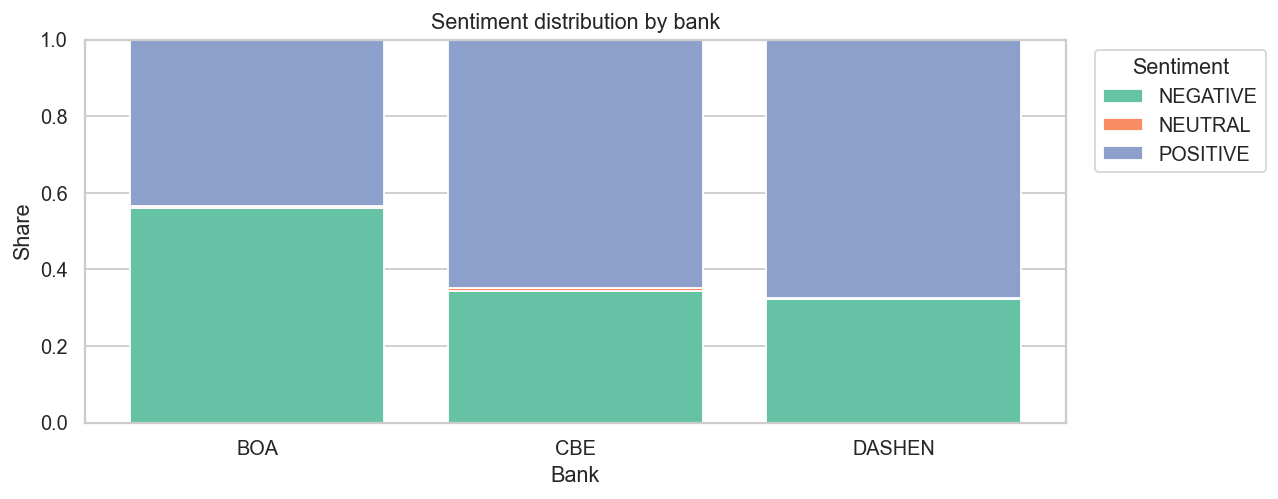

In [14]:
# 9.1 Sentiment distribution (share) by bank
fig, ax = plot_sentiment_distribution(df, normalize=True)
plt.show()

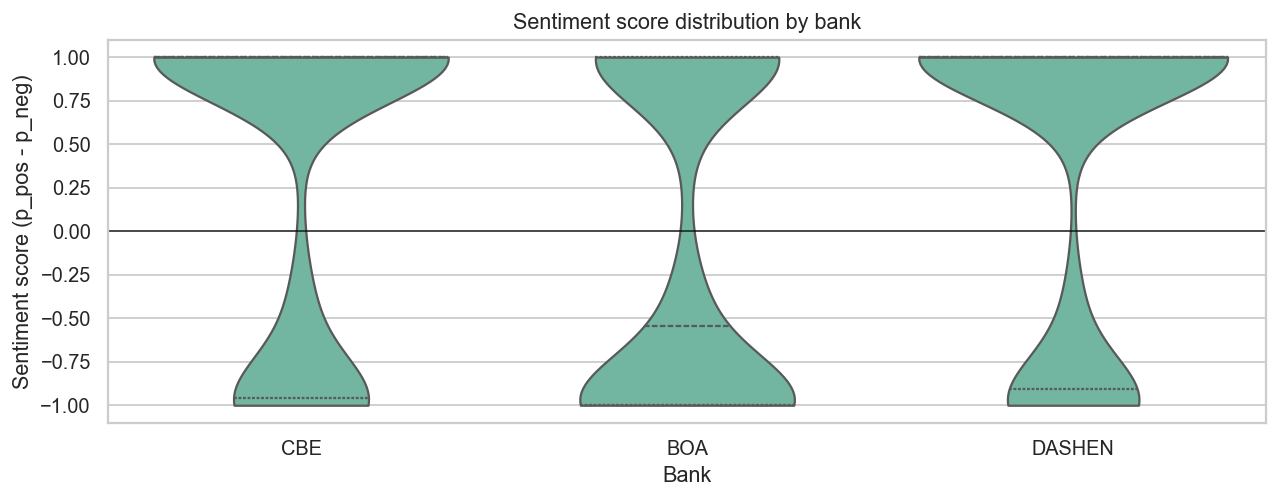

In [15]:
# 9.2 Sentiment score distribution by bank
fig, ax = plot_sentiment_score_violin(df)
plt.show()

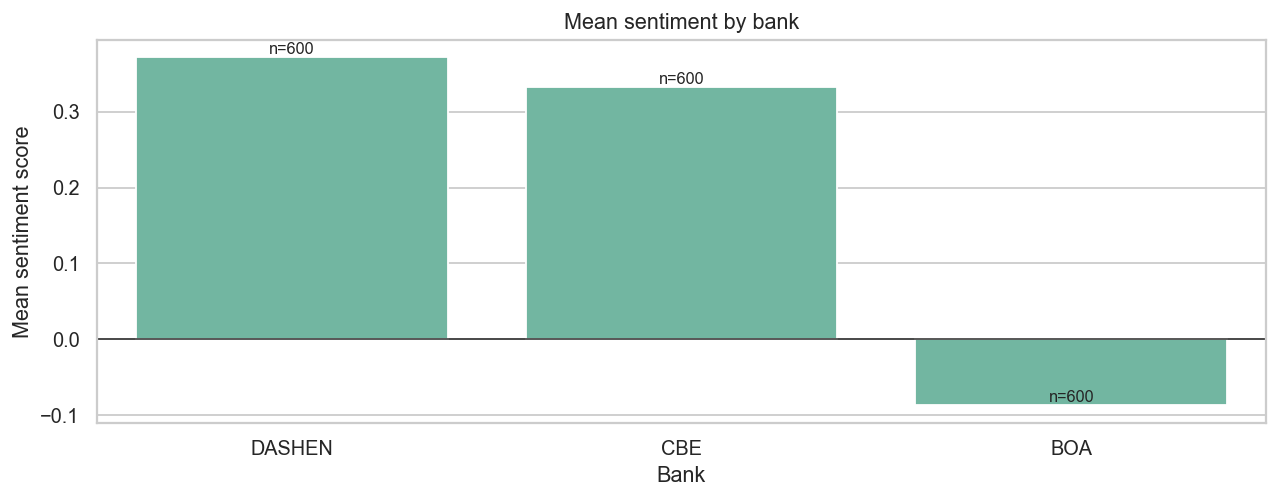

In [16]:
# 9.3 Mean sentiment by bank
fig, ax = plot_mean_sentiment_by_bank(sent_by_bank)
plt.show()

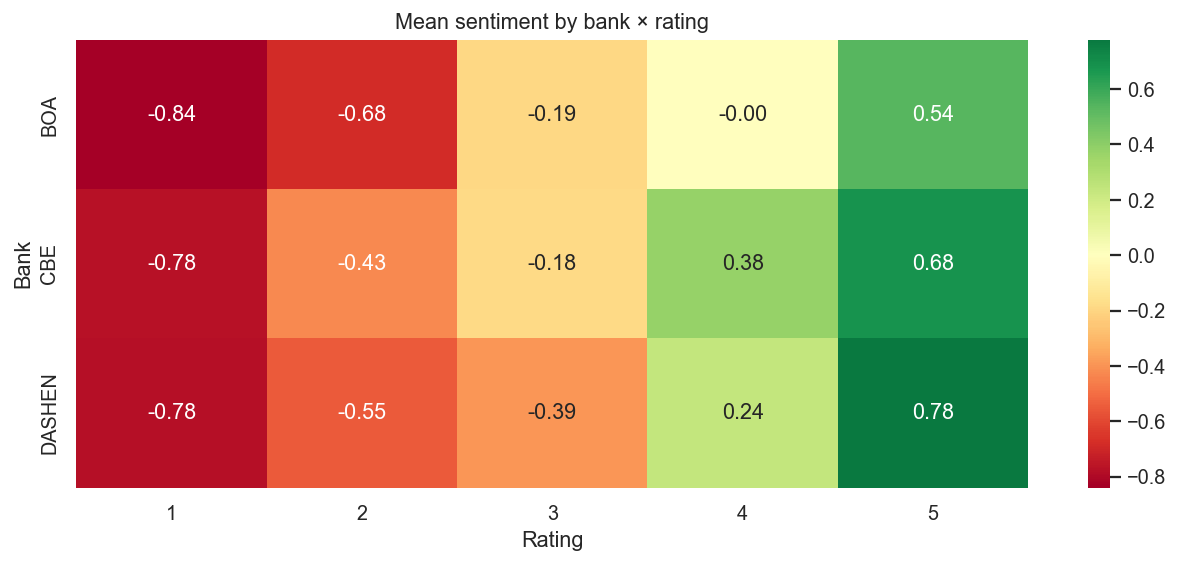

In [17]:
# 9.4 Mean sentiment by bank × rating (heatmap)
fig, ax = plot_sentiment_by_rating_heatmap(sent_by_bank_rating)
plt.show()

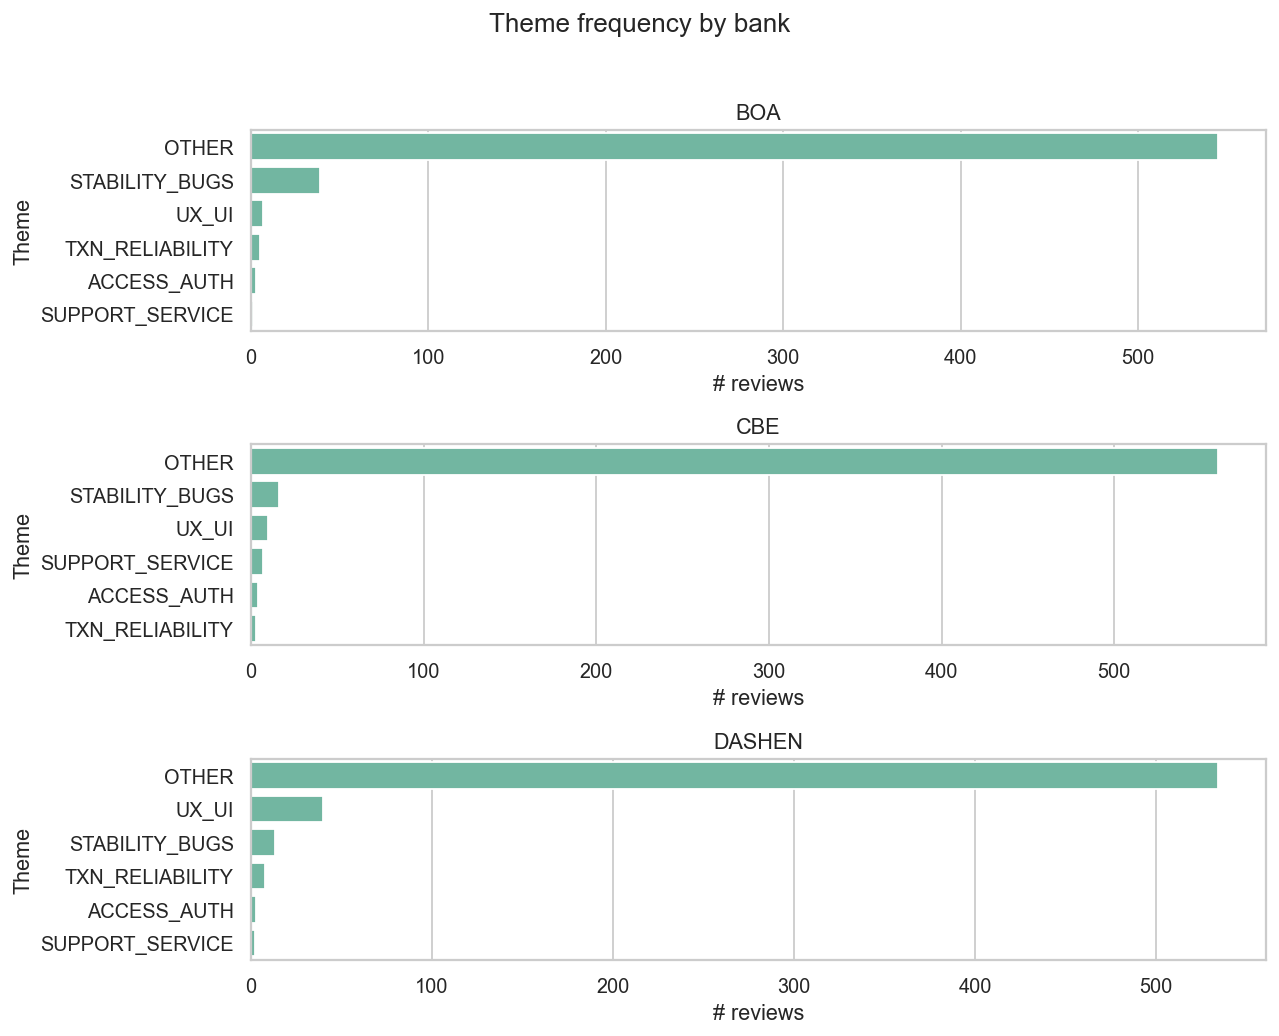

In [18]:
# 9.5 Theme frequency by bank
fig, axes = plot_theme_counts_by_bank(df, top_n=10)
plt.show()

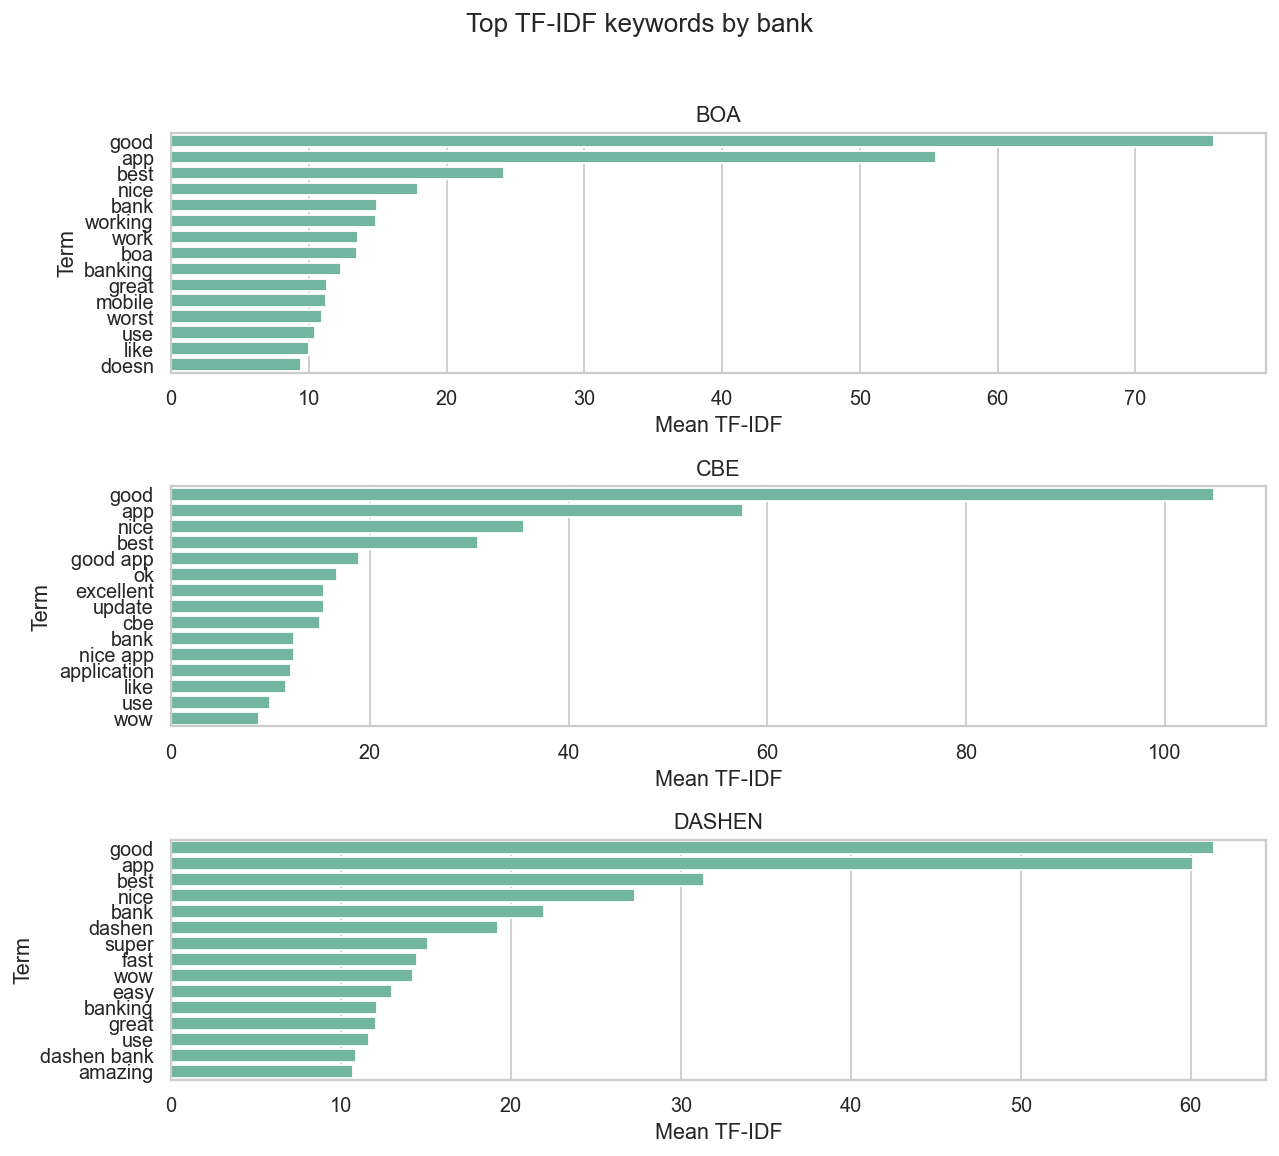

In [19]:
# 9.6 Top TF-IDF keywords by bank
fig, axes = plot_top_keywords_by_bank(kw_by_bank, top_k=15)
plt.show()

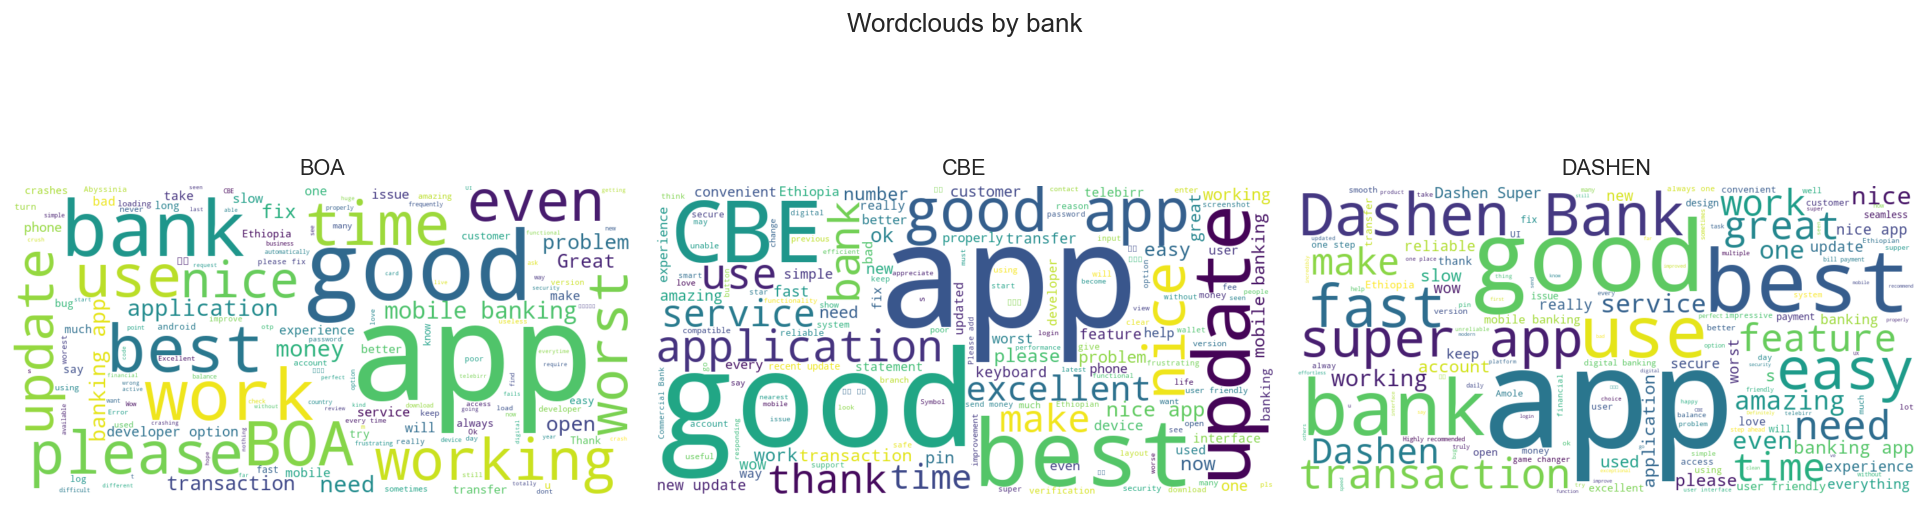

In [20]:
# 9.7 Optional: wordclouds by bank (requires `pip install wordcloud`)
if HAS_WORDCLOUD:
    fig, axes = make_wordcloud_grid(df)
    plt.show()

Saved Task-2 figures to: D:\Python\Week 12\Customer-Experience-Analytics-for-Fintech-Apps-Updated\reports\figures\task 2


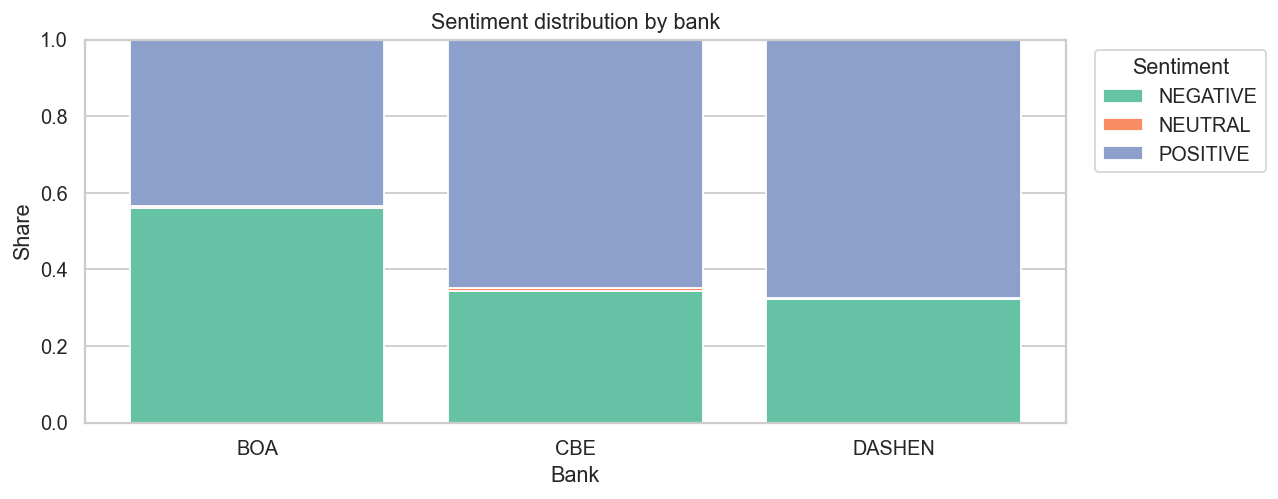

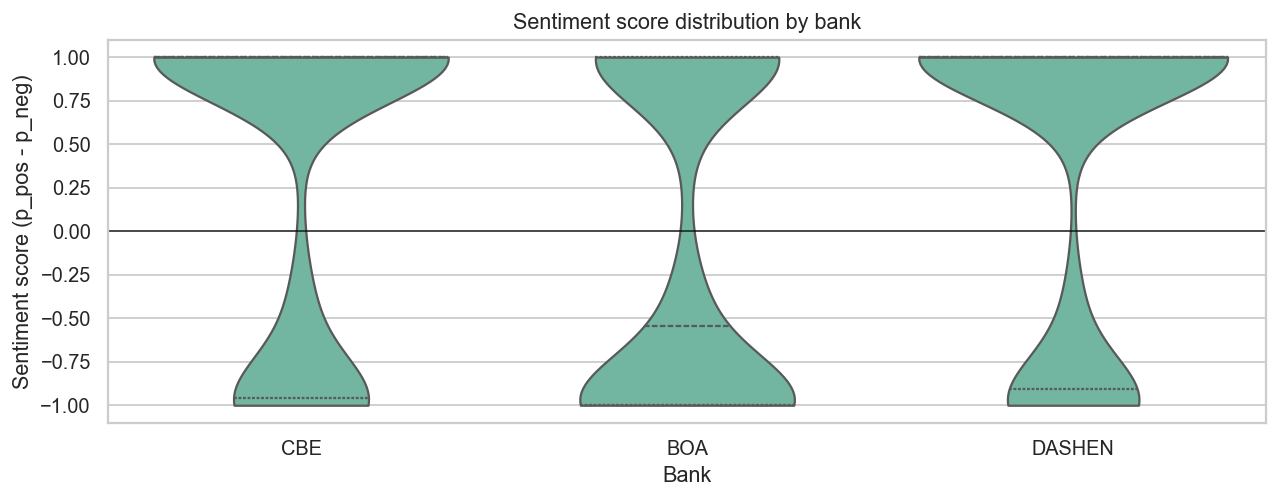

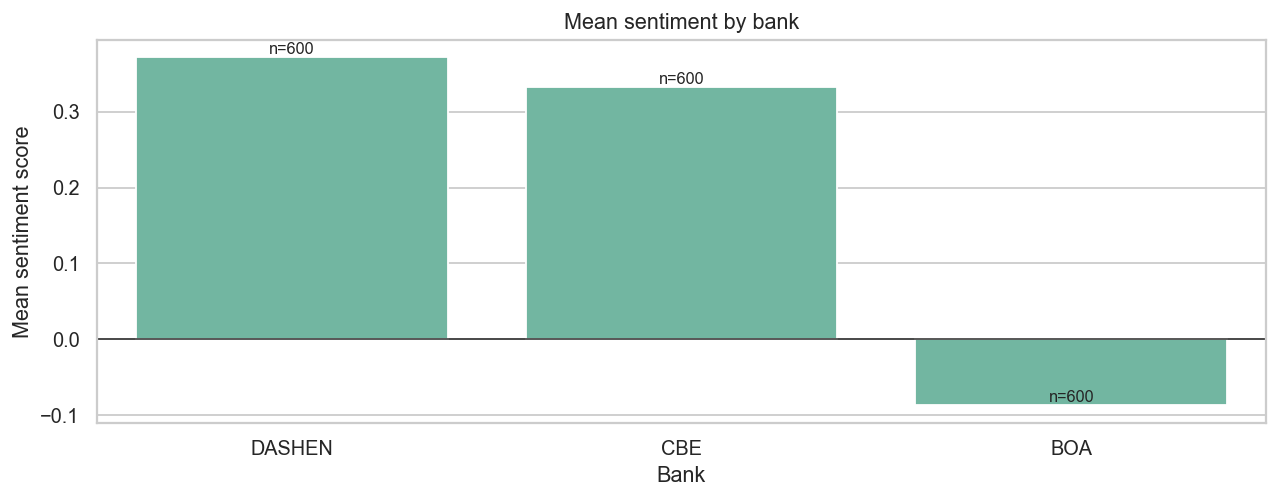

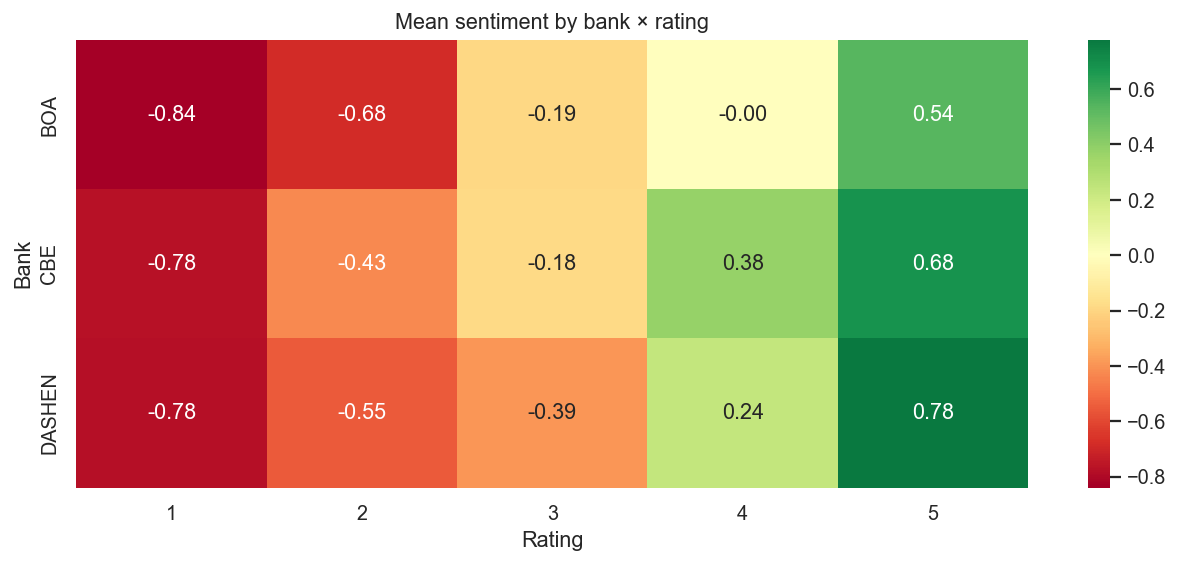

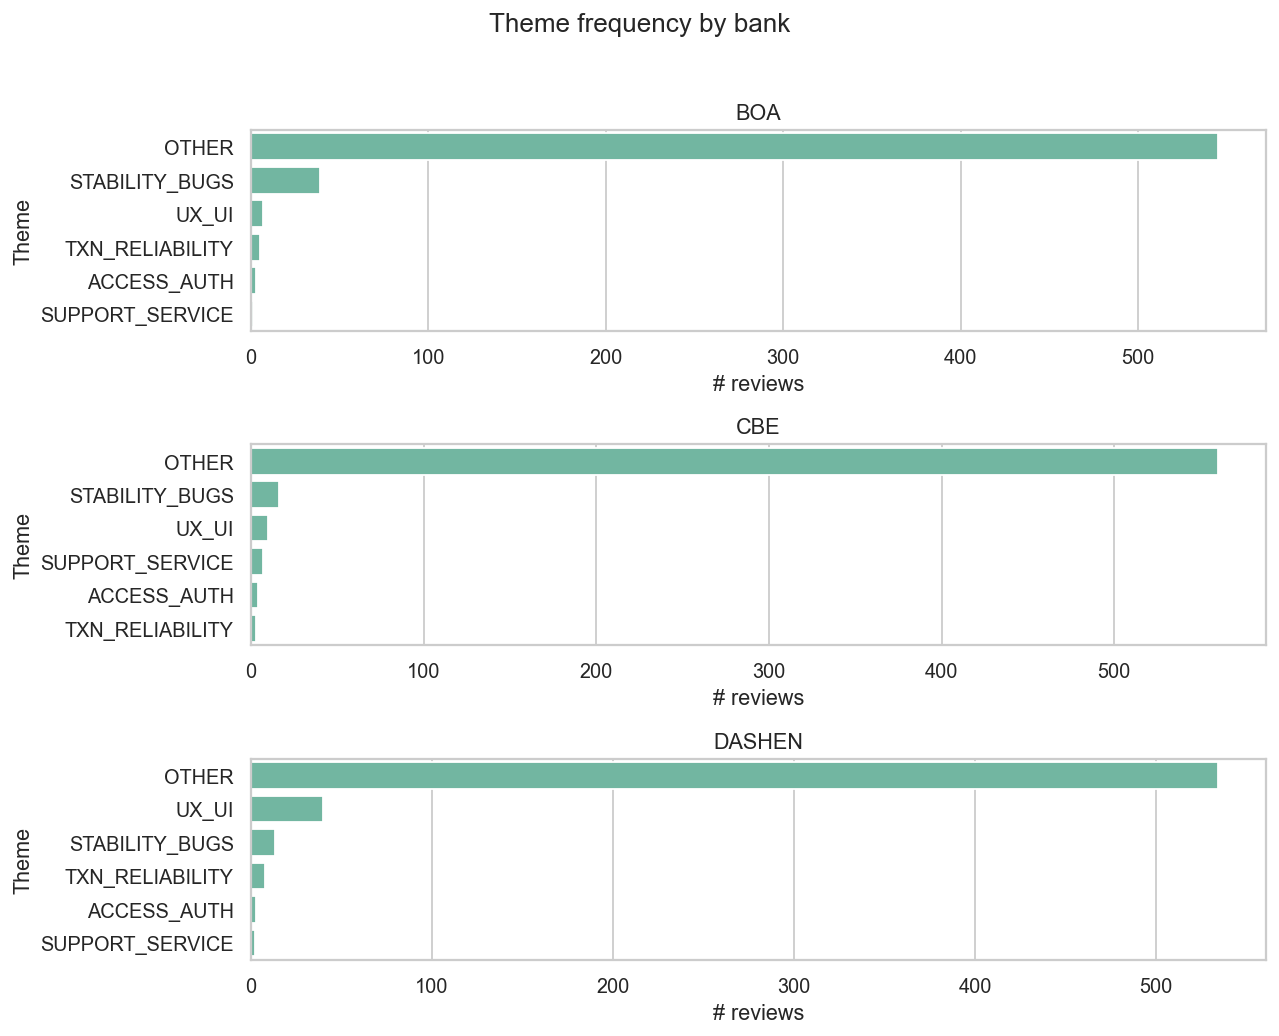

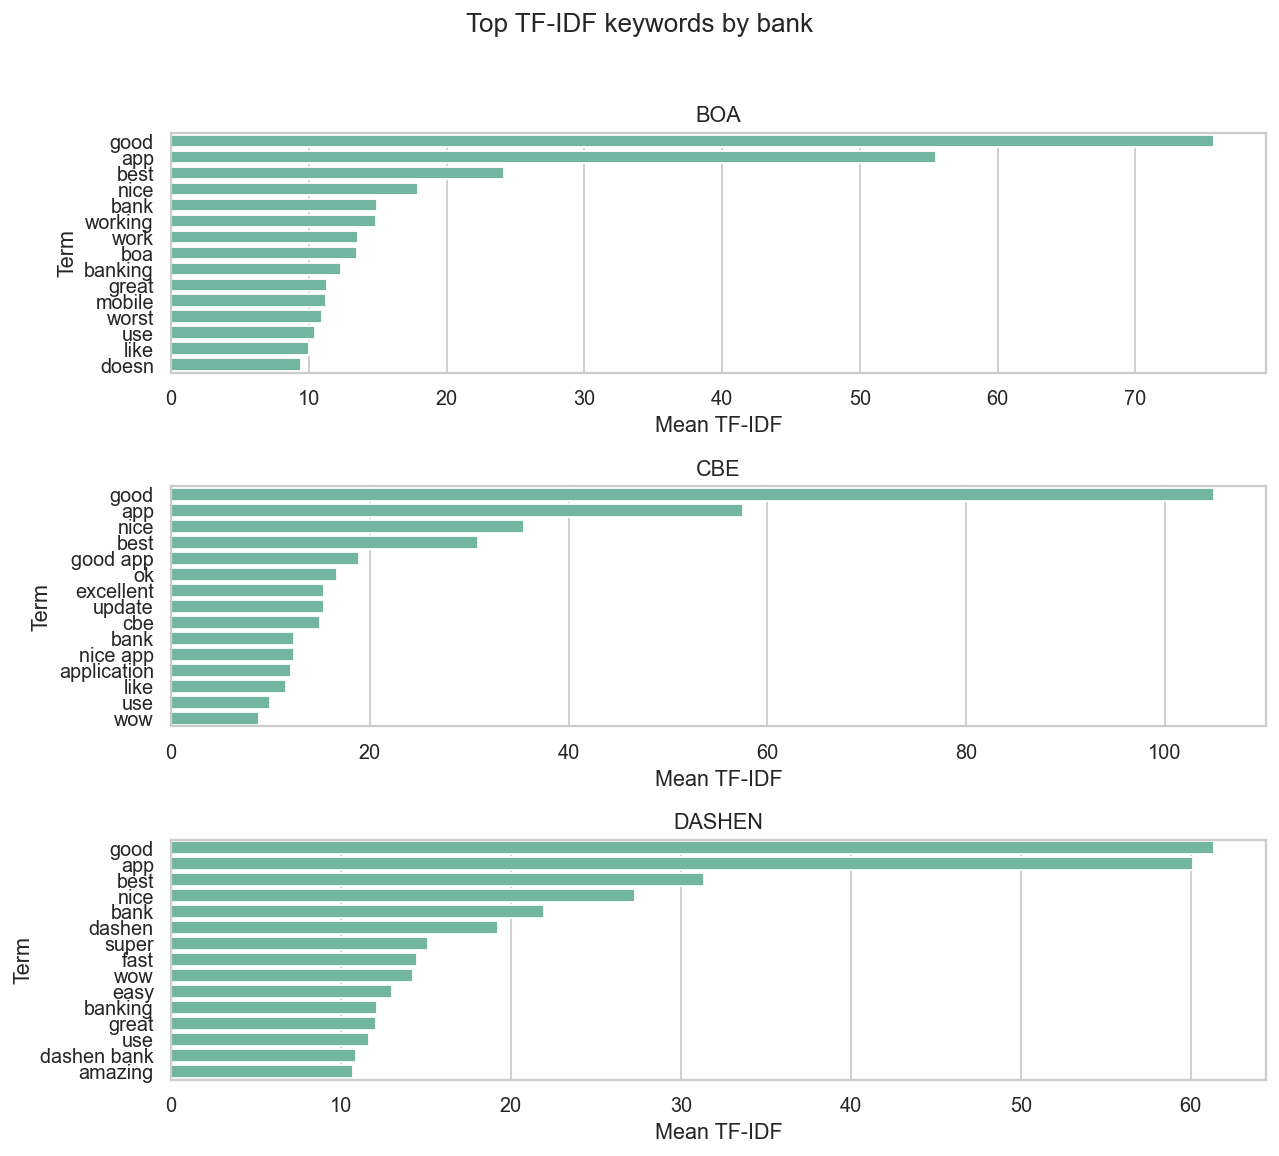

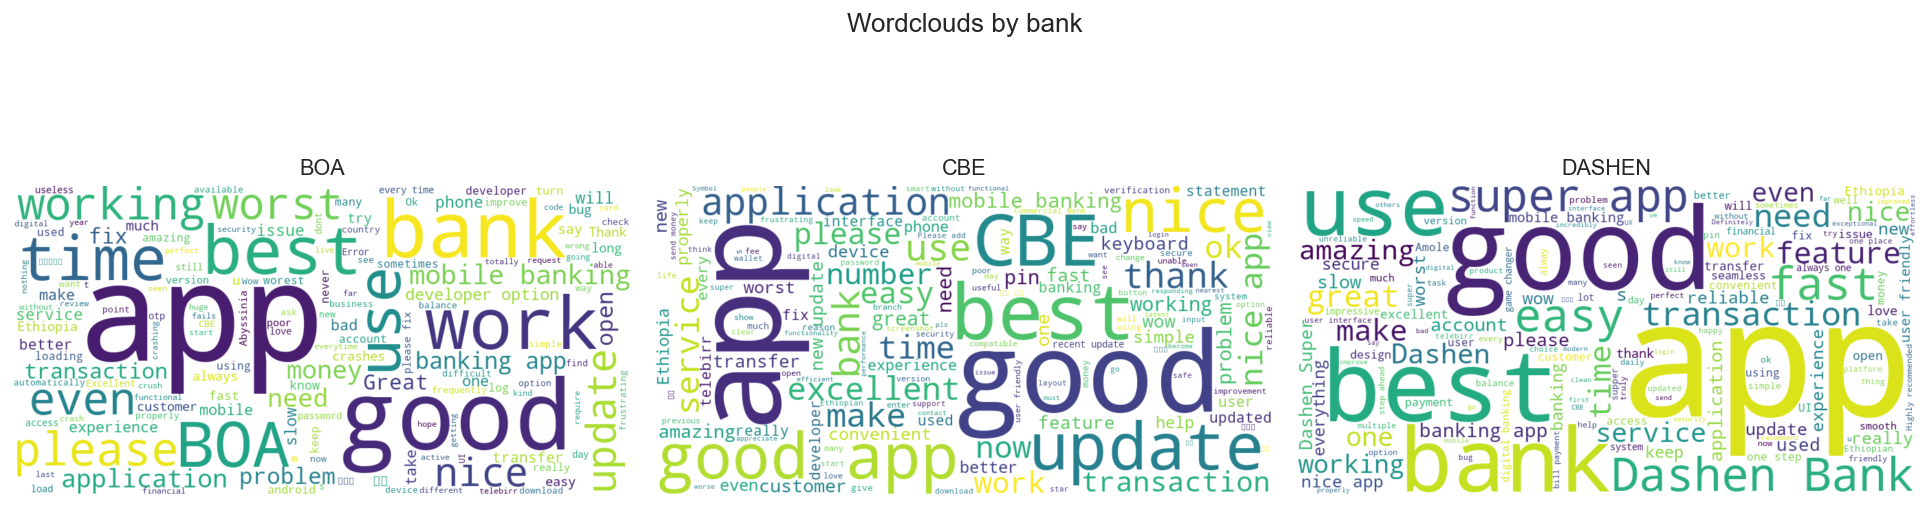

In [22]:
# 9.8 Save Task-2 figures to: ...\reports\figures\task 2
from pathlib import Path

FIG_DIR = Path(
    r"D:\Python\Week 12\Customer-Experience-Analytics-for-Fintech-Apps-Updated\reports\figures\task 2")
FIG_DIR.mkdir(parents=True, exist_ok=True)

# 1) Sentiment distribution by bank
fig, ax = plot_sentiment_distribution(df, normalize=True)
fig.savefig(FIG_DIR / "task2_sentiment_distribution_by_bank.png",
            bbox_inches="tight")

# 2) Sentiment score distribution by bank
fig, ax = plot_sentiment_score_violin(df)
fig.savefig(FIG_DIR / "task2_sentiment_score_violin_by_bank.png",
            bbox_inches="tight")

# 3) Mean sentiment by bank
fig, ax = plot_mean_sentiment_by_bank(sent_by_bank)
fig.savefig(FIG_DIR / "task2_mean_sentiment_by_bank.png", bbox_inches="tight")

# 4) Mean sentiment heatmap: bank × rating
fig, ax = plot_sentiment_by_rating_heatmap(sent_by_bank_rating)
fig.savefig(FIG_DIR / "task2_mean_sentiment_bank_x_rating_heatmap.png",
            bbox_inches="tight")

# 5) Theme frequency by bank
fig, axes = plot_theme_counts_by_bank(df, top_n=10)
fig.savefig(FIG_DIR / "task2_theme_counts_by_bank.png", bbox_inches="tight")

# 6) Top TF-IDF keywords by bank
fig, axes = plot_top_keywords_by_bank(kw_by_bank, top_k=15)
fig.savefig(FIG_DIR / "task2_top_keywords_by_bank.png", bbox_inches="tight")

# 7) Optional: wordcloud grid (only if installed)
if HAS_WORDCLOUD:
    fig, axes = make_wordcloud_grid(df)
    fig.savefig(FIG_DIR / "task2_wordclouds_by_bank.png", bbox_inches="tight")

print("Saved Task-2 figures to:", FIG_DIR)

## 10) How to launch Jupyter with `PYTHONPATH=src`

### PowerShell
```powershell
$env:PYTHONPATH = "src"
jupyter lab
```

### CMD
```bat
set PYTHONPATH=src
jupyter lab
```
